# Predicting Hashtag Use in StackOverflow Questions
Exploring hashtags for StackOverflow questions. By Jordan Jozwiak, Liora Sim, Xiaoxiao Wu, and Akua Abu

In [1]:
%matplotlib inline

import json
import time
import pandas as pd
import numpy as np
import networkx as nx
import requests
from pattern import web
import matplotlib.pyplot as plt
import pattern.web as pw
import operator
import random
from collections import Counter
from pygments.lexers import guess_lexer, guess_lexer_for_filename
from pattern.web import DOM, plaintext
import pylab as pyl

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

Stackoverflow is the flagship Q&A website of the Stackexchange Network. It features questions and answers on a wide range of topics in computer programming. A typical stackoverflow question looks like [this](http://stackoverflow.com/questions/20324749/twitter-api-dotnetopenauth-httpclient-error-could-not-authenticate-you).

We downloaded stackoverflow questions, using the stackexchange API (http://api.stackexchange.com). Stackexchange gives access to its data in JSON format ([example](http://api.stackexchange.com/2.1/questions?pagesize=1&order=desc&sort=activity&site=stackoverflow)). We first registed for an api key. After we got the key, we used the key to get an ancess token that would allow us to download data from the website.

In [2]:
key = 'vhd6*M3uoM7s*0feSj5ywQ(('
access_token = 'pZr0oYcDtx3Y5iQklSlwyw))'

"""
Function
--------
fget_questions(fromdate, todate, pagesize)

Use the stackexchange web API to fetch [pagesize] number of questions asked between fromdate and todate

Parameters
----------
fromdate : Unix Timestamp 
  From Date
todate : Unix Timestamp 
  To Date
pagesize : int
  number of questions to fetch
  
Returns
-------
Dictionary of Questions
"""

def get_questions(fromdate, todate, pagesize):
    options = {
               'access_token' : access_token, 
               'key' : key, 
               'pagesize' : pagesize,
               'fromdate': fromdate,
               'todate' : todate,
               #update filter to include the 'body' field in our question object
               'filter' :'!9f8L76x0L'}
    url = 'https://api.stackexchange.com/2.1/questions?order=desc&sort=activity&site=stackoverflow'
    page = requests.get(url, params=options).text
    return json.loads(page)

In [2]:
"""Download as much data as we can"""

#we started from Monday Dec 9 and worked our way backwards in time
timenow = int(time.time())
day = 86400
fromdate = timenow - day
todate = timenow
pagesize = 100

questions = [];
#there is a quota of 10,000 a day
quota_remaining = 10000
while quota_remaining > pagesize:
    qdict = get_questions(fromdate, todate, pagesize)
    questions.extend(qdict['items'])
    quota_remaining = qdict['quota_remaining']
    todate = fromdate
    fromdate = fromdate - day

#reorganize data into pandas df 
qlist = []
for i in questions:
    qlist.extend(i)
qdict = pd.DataFrame(qlist)

#extract user info to add to qdict
user_id = []
reputation = []
for i in qdict['owner']:
    owner_info = eval(i)
    if 'user_id' in eval(i).keys():
        user_id.append(owner_info['user_id'])
    else:
        user_id.append('')
    if 'reputation' in eval(i).keys():
        reputation.append(owner_info['reputation'])
    else:
        reputation.append('')

qdict['reputation'] = reputation
qdict['user_id'] = user_id     

#save to csv file
qdict.to_csv('questions.csv', index=False,encoding='utf-8')

# Exploratory Analysis

## Exploring the Data

Our data is a random sample of questions post on one of StackExchange's sites over the last five years.  Our goal is to predict the keywords/tags for a question given everything else we know about the question (title, body, code, user, etc.).  The questions are a mix of technical and non-technical questions, so they will not all contain code or be directly related to a specific programming language.  The non-technical questions may require more text analysis while the technical quesitons will also rely on guessing the programming language of any code snippets.

In [2]:
# load data
questions = pd.read_csv('questions.csv')
#filter out corrupted rows
questions = questions[questions['Creation_date'] > 100]
questions = questions[~np.isnan(questions['Question_id'])]
questions = questions[~np.isnan(questions['User_id'])]
questions.reset_index(drop=True)
questions.head()

,Answer_count,Body,Creation_date,Is_answered,Link,Question_id,Score,Tags,Title,View_count,Reputation,User_id
0,0,<p>I took a java class and a VB class this sem...,1386649804,False,http://stackoverflow.com/questions/20486137/ho...,20486137,0,java,How do I learn to WRITE programs from scratch?,1,1,3085406
1,1,<p>Hello all I have a program that is dealing ...,1386649706,False,http://stackoverflow.com/questions/20486115/ho...,20486115,0,python string,How do I delete the first part of a string in ...,8,43,2649920
2,5,<p>I tried using final keyword to array but st...,1386649500,True,http://stackoverflow.com/questions/20486074/wh...,20486074,0,java,Why final is not applicable to array in Java?,26,1,2099274
3,0,<p>I have a number of PHP scripts that I am tr...,1386620377,False,http://stackoverflow.com/questions/20479918/de...,20479918,1,http asp-classic,Determining the length of a UTF-8 response in ...,9,3171,619852
4,0,<p>I have a application that fills in fields o...,1386649779,False,http://stackoverflow.com/questions/20486133/dr...,20486133,0,c# image bitmap gdi,Draw large off screen form to bitmap,2,26,1137759


We first look at the general statistics of this dataset and an example of one of the questions.

In [3]:
x = np.array(questions['Creation_date'])
x = x[~np.isnan(x)]
print "From:", time.ctime(int(x.min()))
print "To: ", time.ctime(int(x.max()))
# number of questions
n_questions = len(questions)
print "Number of questions: %i" % n_questions
print "Number of unique users:", len(questions['User_id'].unique())
print " "
# print the first row
print questions[['Question_id', 'Title', 'Body', 'Tags']].irow(0)

From: Thu Jul 31 17:42:52 2008
To:  Mon Dec 09 23:30:04 2013
Number of questions: 189640
Number of unique users: 111038
 
Question_id                                         2.048614e+07
Title             How do I learn to WRITE programs from scratch?
Body           <p>I took a java class and a VB class this sem...
Tags                                                        java
Name: 0, dtype: object


Our full dataset deals with roughly 190,000 questions - a sizable number, but still just a fraction of more than 10 million total questions between the stack exchange sites.  The title is formatted as a plain string, and does not need any additional manipulation.  The body of the question is in HTML format, which makes it easy to extract code snippets, but also requries us to clean the text up in order to look at the words.  The tags are separated by spaces and seem to have hyphens between them for multi-word names.

To get a better picture of the langauge use in the tags, title, and body, we look at the word frequency per each question and across all the questions.  To help with this process we create a function to count the number of words in a series.

In [4]:
"""
Function
--------
count_words

Parameters
----------
series : Series
  series from dataframe column
  
Returns
--------
A dictionary
  with key/value pairs of word => frequency
"""
def count_words(series):
    n_tags = {}
    for tags in series:
        tags = tags.split()
        for tag in tags:
            tag = tag.lower()
            if tag in n_tags:
                n_tags[tag] += 1
            else:
                n_tags[tag] = 1
    return n_tags

In [5]:
def bar_style(x, y, xlabels):
    plt.figure(figsize=(15, 4))
    plt.bar(range(len(y)), y, align='center')
    plt.xticks(range(len(xlabels)), xlabels, rotation='vertical', fontsize=7)
    limits = plt.xlim(0, len(x))
    remove_border()

### Analysis of Tags

Let's start by answering some basic questions about the tags.  What are the most common words?  What is the distribution of their frequencies?  How many tags can be used per question?  How many tags typically are used per question?  And when we get to exploring the title of the questions, if a previously tagged word is used in the title of a question, what is the probability that it will show up as a tag.

We start by exploring the frequency distribution of all the observed tags using our previously defined *count_words* function.

In [6]:
# count tag occurrences
n_tags = count_words(questions.Tags)

# create new dataframe for tags and sort by their frequencies
tags = pd.DataFrame([{'tag': x[0], 'freq': x[1]} for x in n_tags.iteritems()])
tags = tags.set_index('tag')
tags = tags.sort('freq', ascending=False)
print tags.head()

             freq
tag              
java        17338
c#          15810
javascript  13472
android     13097
php         12321


It is immediately evident that the most common tags are programming languages and environments (and therefore probably related to technical questions).  Based on the quick decrease in frequency, it also looks as if there will be a long tail for tags with a low frequency. We proceed to look at the most popular tags and the portion of total tags covered by the 100 most popular tags.  If the top tags make up a large portion of the data then we may use these to decrease the complexity of our algorithms.

In [7]:
# most common words in series
print "Number of unique tags: %d" % len(n_tags)
print "First 100 tags make up %.2f percent of total tags" % ((tags.sort('freq', ascending=False).freq.values[:100].sum()  / float(tags.sort('freq', ascending=False).freq.values.sum())) * 100)

print "Most popular tags:"
print tags[:20]

Number of unique tags: 21058
First 100 tags make up 42.98 percent of total tags
Most popular tags:
                freq
tag                 
java           17338
c#             15810
javascript     13472
android        13097
php            12321
jquery          9127
python          8009
c++             6686
.net            6599
iphone          6105
html            5777
asp.net         5261
css             4943
ios             4718
mysql           4375
objective-c     4234
sql             4116
ruby-on-rails   3915
c               3465
ruby            2973


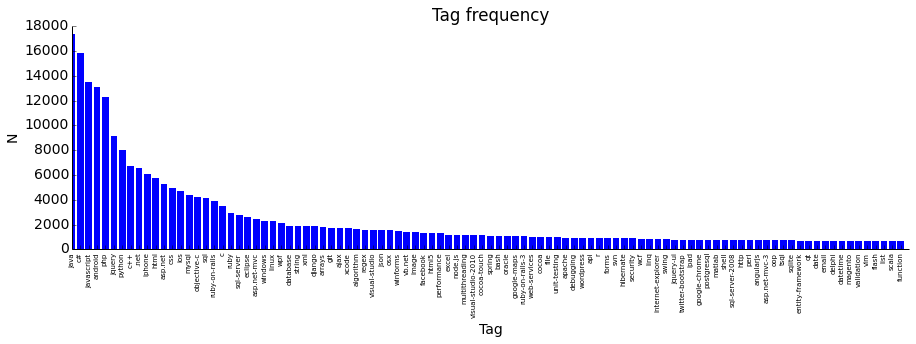

In [14]:
# bar chart of 100 most common tags
x = range(100)
xlabels = tags.index.values[:100]
y = tags.freq.values[:100]
bar_style(x, y, xlabels)
plt.xlabel("Tag")
plt.ylabel("N")
plt.title("Tag frequency")

The most popular tags make up less than 1% of the unique tag words, but these tags account for about 40% of the tag occurrences.  If we can correctly predict these tags, then most of our battle will already be won.

We also need to look at the number of tags per question.  This will be especially important when predicting how many tags to give a particular question.  We certainly could give the five most applicable tags (assuming five exist), but perhaps some questions inherently merit fewer tags.  Or perhaps tags are determined solely based on tag relevance.

In [8]:
# count the number of tags per question
questions['n_Tags'] = [len(x.split()) for x in questions.Tags]

# number of tags per question
print "Mean number of tags per question: %.2f" % np.array(questions.n_Tags).mean()

Mean number of tags per question: 3.00


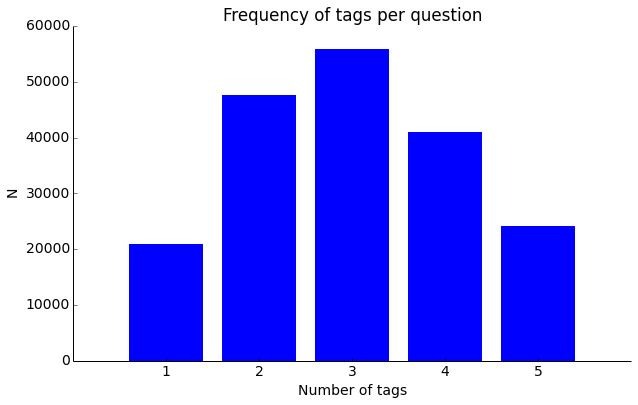

In [9]:
grouped = questions.groupby('n_Tags')
plt.bar(range(1, 6), grouped.Question_id.count(), align='center')
plt.xticks(range(1, 6))
remove_border()
plt.xlabel('Number of tags')
plt.ylabel('N')
plt.title('Frequency of tags per question')

This frequency distribution for the number of tags appears normal with a mean of 3.  We immediately researched this and found that stack exchange sites require at least one tag and have a maximum of five.  We will need to keep in mind that in addition to predicting the correct tags for a question, we should also make sure that we are not predicting too few or too many tags.

In [10]:
# look at the distribution of tag frequencies
counts = tags.freq.values
print 'Percent of possible tagged words that are only used once: %.2f' % (len(counts[counts == 1]) / float(len(counts)) * 100)
print 'Percent of single-use tagged words in all tags: %.2f' % (counts[counts == 1].sum() / float(counts[counts > 1].sum()) * 100)
print 'Median number of times a tag is used: %d' % np.median(counts)
print 'Mean number of times a tag is used: %.2f' % counts.mean()
print 'Standard deviation of number of times a tag is used: %.2f' % counts.std()

Percent of possible tagged words that are only used once: 29.72
Percent of single-use tagged words in all tags: 1.11
Median number of times a tag is used: 3
Mean number of times a tag is used: 27.02
Standard deviation of number of times a tag is used: 283.33


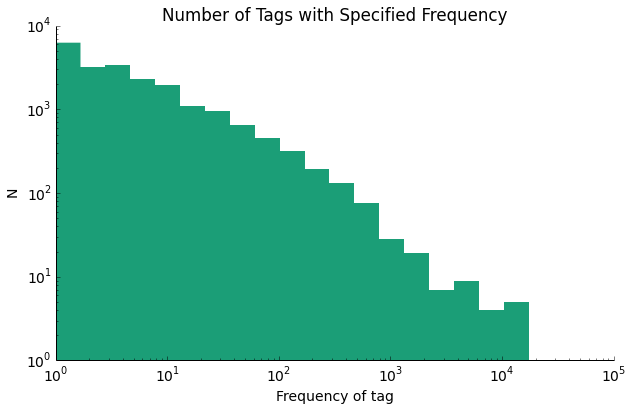

In [11]:
# histogram of tag frequencies
plt.hist(counts, bins=np.logspace(np.log10(min(counts)), np.log10(max(counts)), 20), log=True)
plt.gca().set_xscale("log")
remove_border()
plt.xlabel('Frequency of tag')
plt.ylabel('N')
plt.title('Number of Tags with Specified Frequency')

The linearity of the log-log plot tells us that this follows a powerlaw distribution. This analysis reveals some extremely important points.
-About one-third of tags are used only once, should we should be careful not to overfit our model due to this scarcity
-The median number of times a tag is used is 2.  Again, this emphasizes that we should not overfit.
-Single-use tags make up only 1% of the data, indicating that rarely used tags are much less important than popular tags

### Title exploration

Any good title should quickly reveal the subject matter of the question.  Users will also be concerned about the quality and specificity of their title since they want their question to be seen, understood, and answered quickly. For this reason, we suspect that the words in the title will be most more essential to predicting tags than the words in the body.

We begin by looking at the frequency of word occurrences, just like we did with the tags.

In [12]:
# construct a dataframe of the most common words in the title
n_titles = pd.DataFrame([{'word': x[0], 'freq': x[1]} for x in count_words(questions.Title).iteritems()])
n_titles = n_titles.set_index('word')
n_titles = n_titles.sort('freq', ascending=False)
print "Most popular words in titles"
print n_titles[:20]

Most popular words in titles
        freq
word        
to     61995
in     53496
a      43769
how    39867
the    26711
with   19174
of     19038
and    18101
for    16849
is     16411
on     14413
i      14175
from   13195
using  12274
not    10836
-       9867
an      9784
do      8770
can     8258
file    6946


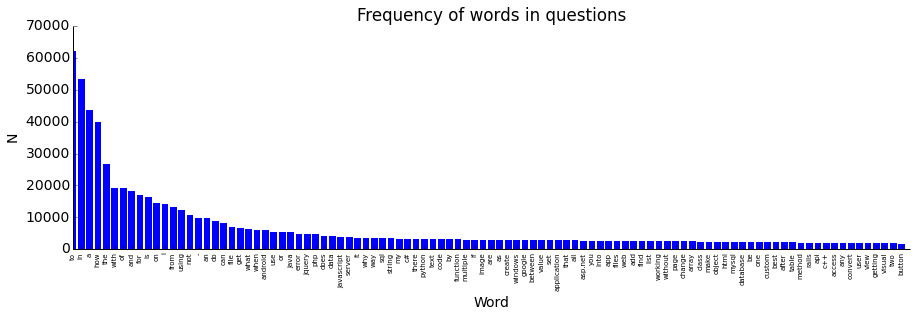

In [13]:
# bar chart of most common words in title
x = range(100)
xlabels = n_titles.index.values[:100]
y = n_titles.freq.values[:100]
bar_style(x, y, xlabels)
plt.xlabel("Word")
plt.ylabel("N")
plt.title("Frequency of words in questions")

The above words make it clear that the most common words in the title are common English words, especially articles and prepositions.  This is completely expected and a the phenomenon would also occur in the content of the question.  *Do we want to filter by tagged words to see what the frequency of the most commonly tagged words are in the questions?*

We now make some preliminary estimates about how the text of the title affects the tagged words.  To do this we look at the occurrence of tagged words in the title.  We also use our complete set of previously tagged words to flag words in a title that might be tag-worthy and then look at the percent of those words that are actually used as tags.  In a way, this is the simplest (and therefore very bad) model for tagging.

In [14]:
# number and percent of tagged words in title
tags_in_title = []
for i in range(len(questions)):
    question = questions.irow(i)
    q_tags = question['Tags'].split()
    in_title = 0
    for tag in q_tags:
        if tag in question['Title']:
            in_title += 1
    tags_in_title.append(in_title)
questions['tags_in_title'] = tags_in_title 
questions['percent_tags_in_title'] = questions.tags_in_title / np.array(questions.n_Tags).astype(float)
print questions[['Title', 'Tags', 'n_Tags', 'tags_in_title', 'percent_tags_in_title']].head()

                                               Title                 Tags  \
0     How do I learn to WRITE programs from scratch?                 java   
1  How do I delete the first part of a string in ...        python string   
2      Why final is not applicable to array in Java?                 java   
3  Determining the length of a UTF-8 response in ...     http asp-classic   
4               Draw large off screen form to bitmap  c# image bitmap gdi   

   n_Tags  tags_in_title  percent_tags_in_title  
0       1              0                   0.00  
1       2              2                   1.00  
2       1              0                   0.00  
3       2              0                   0.00  
4       4              1                   0.25  


In [16]:
percent_tags_in_title = questions.percent_tags_in_title.values
print 'Mean percent of tags that show up in the title: %.2f' % (percent_tags_in_title.mean() * 100)
print 'Percent of Questions with NO Tags in Title: %.2f' % (len(percent_tags_in_title[percent_tags_in_title == 0]) / float(len(percent_tags_in_title)) * 100)
print 'Percent of Questions with ALL Tags in Title: %.2f' % (len(percent_tags_in_title[percent_tags_in_title == 1]) / float(len(percent_tags_in_title)) * 100)

Mean percent of tags that show up in the title: 16.22
Percent of Questions with NO Tags in Title: 64.82
Percent of Questions with ALL Tags in Title: 3.89


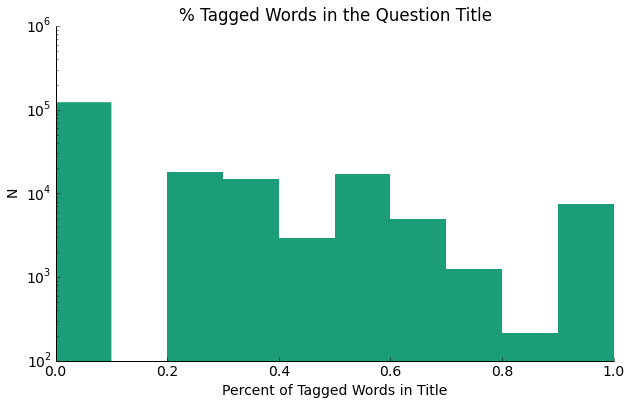

In [17]:
# histogram of percent frequencies
plt.hist(percent_tags_in_title, log=True)
remove_border()
plt.title('% Tagged Words in the Question Title')
plt.xlabel('Percent of Tagged Words in Title')
plt.ylabel('N')

The fact that 65% of questions don't have any of their tags in the title is a huge red flag.  This means that we will definitely need to look at related words for predicting tags or look at other sources for estimating tags (the user's habits, the code in the question, the text in the question).  On the other hand, the mean number of tags in the question title is 16% and 4% of questions have all the tags in their question title.  Temporarily ignoring the possibility of false positives, we could optimistically interpret this as definitely knowing the tags for some  small portion of the data based solely on the question's title.

If we are really trying to predict the tags that a user would choose for a question, then we don't always want to use all five tags.  Since we don't know how many tags a question will have but we know that it needs to have between 1 and 5 tags, we might need a way to predict the number of tags we should use.

In [180]:
questions['n_Title_words'] = [len(x.split()) for x in questions.Title]
questions[['Score', 'View_count', 'Reputation', 'n_Tags', 'percent_tags_in_title']].corr()

,Score,View_count,Reputation,n_Tags,percent_tags_in_title
Score,1.000000,0.702993,0.121481,0.007652,0.000398
View_count,0.702993,1.000000,0.089150,-0.002491,0.007115
Reputation,0.121481,0.089150,1.000000,0.008313,-0.019158
n_Tags,0.007652,-0.002491,0.008313,1.000000,-0.057165
percent_tags_in_title,0.000398,0.007115,-0.019158,-0.057165,1.000000


The correlation between the user's reputation and the number of tags is .01, which is extremely low.  As such, we probably cannot estimate the number of tags based on pre-defined attributes of the user.

For the questions that have previously tagged words in the title, we will want to know how accurately we can predict the tags.  To do this we first create a list of predicted tags based on words that have already been tagged before (filtering by the top 100 tags to focus on significant words and improve the runtime).  Then we look at the number of those tags that actually showed up as tags for that question.  From there we can determine our percent accuracy.

In [181]:
#**********RUNTIME: VERY SLOW*************************

# probability that tagged word is used given that it exists in our tag set
words = tags.index.values[:100]

# list of percent correct for each question
percents = []

# iterate through all the questions
for i in range(len(questions)):
    
    # get the question, tags, and title words
    question = questions.irow(i)
    q_tags = question['Tags'].split()
    title_words = question['Title'].split()
    
    # tagged words in title that appear in tag set
    pred_tags = np.intersect1d(title_words, words)
    
    # matched tags that also appear in question tags
    cor_tags = np.intersect1d(pred_tags, q_tags)
    
    # only include questions that had words were tagged before
    if len(pred_tags) > 0:
        percents.append(len(cor_tags) / float(len(pred_tags)))

print 'Of words in question that match tag set, percent that are also used as a tag: %.2f' % (np.array(percents).mean() * 100)

Of words in question that match tag set, percent that are also used as a tag: 50.50


We intuitively know that not all words will have equally likely probabilities of predicting a tag.  Perhaps when 'SQL' is used in the title of a question, there is a 90% chance that it is a tag for that question.  On the other hand, since 'function' is a very common word that is occassionally used as a tag, it might only be a trigger for the question's tag 30% of the time.  Below we look at the tags that have the highest percentage of showing up as a tag when used in the title.  We do this by looking at the number of times they are used in the title, tag, and in both places.

In [18]:
#**********RUNTIME: VERY SLOW*************************

# create now columns for in_tag, in_title, in_both
tags['in_tag'] = np.zeros(len(tags))
tags['in_title'] = np.zeros(len(tags))
tags['in_both'] = np.zeros(len(tags))

# common tags from the complete tag set
words = tags.index.values[:100]

# iterate through all the questions
for i in range(len(questions)):
    
    # get the question, tags, and title words
    question = questions.irow(i)
    q_tags = question['Tags'].split()
    title_words = list(set([x.lower() for x in question['Title'].split()]))

    # update stats for each tag in question
    for q_tag in q_tags:
        tags['in_tag'][q_tag] += 1
        
    # update stats for each tag in title
    pred_tags = np.intersect1d(title_words, words)
    for pred_tag in pred_tags:
        tags['in_title'][pred_tag] += 1
    
    # matched tags that also appear in question tags
    cor_tags = np.intersect1d(pred_tags, q_tags)
    for cor_tag in cor_tags:
        tags['in_both'][cor_tag] += 1
        
print tags.head()

             freq  in_tag  in_title  in_both
tag                                         
java        17338   17338      5228     4845
c#          15810   15810      3306     3079
javascript  13472   13472      3729     3404
android     13097   13097      5961     5794
php         12321   12321      4542     4377


With the sets of in_title and in_both, we can calculate a percentage of how often a word is used as a tag given that it is used in the title.  We look at the results in order of their usage in both the title and the tag to get a picture of the words where this effect is most important.

In [19]:
# calculate probability of being a tag given word in title
tags['prob'] = tags.in_both / tags.in_title.astype(float)
print tags.head()

             freq  in_tag  in_title  in_both      prob
tag                                                   
java        17338   17338      5228     4845  0.926741
c#          15810   15810      3306     3079  0.931337
javascript  13472   13472      3729     3404  0.912845
android     13097   13097      5961     5794  0.971985
php         12321   12321      4542     4377  0.963672


In [20]:
tags[tags.prob.notnull()].sort('prob', ascending=False)[:20]

,freq,in_tag,in_title,in_both,prob
tag,,,,,
entity-framework,710,710,2,2,1.000000
twitter-bootstrap,786,786,9,9,1.000000
google-chrome,781,781,2,2,1.000000
unit-testing,963,963,8,8,1.000000
google-maps,1070,1070,1,1,1.000000
angularjs,740,740,331,330,0.996979
delphi,689,689,295,293,0.993220
matlab,777,777,402,399,0.992537
node.js,1162,1162,317,313,0.987382


This table shows us great news!  When words like Android or Python show up in the title, we know that they should also have that tag about 95% of the time.  The same holds for most of the other 20 top tags.  The least predictive tag is *string*, which only shows up as a tag about 30% percent of the time.

# User Exploration

Number of unique owners: 111038
Max number of questions asked by any user: 146


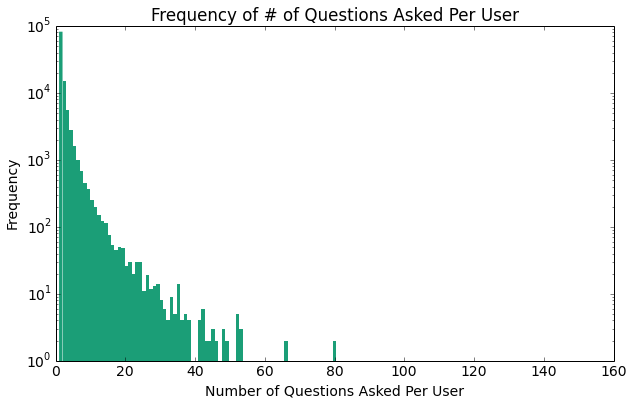

In [21]:
print "Number of unique owners:", len(questions['User_id'].unique())
grouped = questions.groupby('User_id')
owners_num_questions = np.array(grouped.size())
print "Max number of questions asked by any user:", owners_num_questions.max()
x = plt.hist(owners_num_questions,146, log=True)
plt.xlabel('Number of Questions Asked Per User')
plt.ylabel('Frequency')
plt.title('Frequency of # of Questions Asked Per User')

We wanted to see if the number of questions a user asks in this period has any relationships with the percentage of duplicated tags they use. We are interested in this question, because the hypothesis is that the questions they ask will be in similar fields and they will have similar tagging behavior.

(0, 160.0)

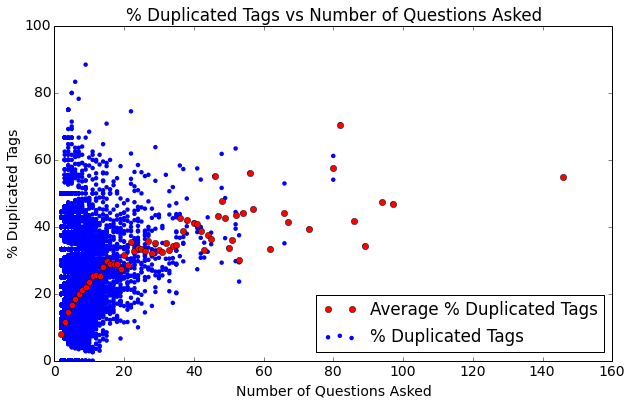

In [35]:
questions['Tags_list']  = [x.split( ) for x in questions['Tags']]
grouped = questions.groupby('User_id')
grouped_tag_list = grouped['Tags_list'].agg({'Duplicate_Percent':lambda x: 1 - float(len(set(np.sum(x))))/len(np.sum(x))})
userdf = pd.DataFrame(grouped_tag_list).join(grouped['User_id'].agg({'Size':np.size}))
userdf = userdf[userdf.Size > 1]
plt.scatter(userdf.Size, userdf.Duplicate_Percent*100, label = '% Duplicated Tags')
grouped1 = userdf.groupby('Size')
plt.plot(grouped1.size().keys(), grouped1['Duplicate_Percent'].agg(np.mean)*100,'ro', label = 'Average % Duplicated Tags')
plt.xlabel('Number of Questions Asked')
plt.ylabel('% Duplicated Tags') 
plt.title('% Duplicated Tags vs Number of Questions Asked')
plt.legend(loc=4)
pyl.ylim(0, pyl.ylim()[1])
pyl.xlim(0, pyl.xlim()[1])

# Question Body Exploration

Body of the question is an exploration of the problem.  It typically involves explaining the user's problem, explaining their environment, their goal, showing some example code, guessing why it doesn't work, and putting forth a potential hypothesis.  However, this format can vary greatly, as can the quality of the question.  This variation is part of the reason that stack exchange questions have scores associated with them, allowing users to vote questions up or down depending on whether they question topic and structure are good.

## Code Snippets

This high amount of variation in the text and format of a question's body will probably cause more noise than useful data.  However, one part of the question body that is unique to that part of the question are the code snippets.  Users posting technical questions often post a snippet of their code when asking for advice so that other users can point out flaws or syntax errors.  By looking at the code snippets with a syntax analyzer (using the pygments library function *guess_lexer()*), we can attempt to guess the coding language for a question.  And since our previous analysis has shown that the most common tags are generally programming languages, accurately predicting this may be extremely helpful to our actual prediction.

In [187]:
# attempt to identify coding language for each question
lang = []
for body in questions.Body:
    
    # parse HTML body of question
    body = DOM(body)
    
    # get code snippets
    code = body.by_tag('code')
    
    # predict language from first snippet if exists
    if len(code) > 0:
        code = code[0].content
        lang.append(guess_lexer(code).name.lower())
    else:
        lang.append(None)
        
questions['lang'] = lang
questions[['Title', 'Tags', 'lang']].head()

,Title,Tags,lang
0,How do I learn to WRITE programs from scratch?,java,None
1,How do I delete the first part of a string in ...,python string,c
2,Why final is not applicable to array in Java?,java,None
3,Determining the length of a UTF-8 response in ...,http asp-classic,c
4,Draw large off screen form to bitmap,c# image bitmap gdi,None


In [188]:
print "Number of times each language was predicted:"
print questions[['lang']].groupby('lang').count().sort('lang', ascending=False)

Number of times each language was predicted:
                      lang
lang                      
c                    93833
javascript+lasso      8456
objective-c           3863
actionscript 3        1781
systemverilog         1475
css+lasso              767
ini                    663
genshi                 486
debian sourcelist      405
prolog                 298
matlab                 167
perl                   151
bash                   139
restructuredtext        97
numpy                   85
aspx-cs                 47
scalate server page     41
django/jinja            38
xml+lasso               31
gas                     13
objective-j             11
tex                      9
python 3                 9
ruby                     8
diff                     8
aspx-vb                  6
groff                    5
smarty                   5
coq                      3
reg                      3
logos                    1
html+lasso               1


In [189]:
print "Percent of questions with some language prediction: %.2f" % (len(questions[questions.lang.notnull()]) / float(len(questions)) * 100)

Percent of questions with some language prediction: 59.54


60% of questions have some snippet of code that we can use for prediction.  Interestingly, the first several questions in our data set did not have any code snippets.  There questions did, however, have a tag in their title.  This is likely a good thing for our analysis since it may indicate that the code snippets and predicting tags from the title are not overlapping sets.  That is to say, these different methods are improving our predictions for different parts of the data.  We also notice that the some languages are predicted with unusual formatting, such as *javascript+lasso*.  When users tag a question on stack exchange they are much more likely to tag *javascript* than *lasso*.  For this reason we will split these lexers and just look at the primary name (the part before the "+").

In that same way that we predicting which tags in the title were the best signals for actual tags, we look at the estimated languages that best predict a tag.  In this case we are probably testing the efficacy of the lexer guesser than anything else.

In [190]:
"""
Function
--------
count_correct_lang

Parameters
----------
questions : DataFrame
  DataFrame of questions
  
Returns
--------
A int
  the number of correctly guessed languages
"""
def count_correct_lang(questions):
    correct = 0
    
    # loop through questions
    for i in range(len(questions)):
        
        # get question and tags
        question = questions.irow(i)
        q_tags = question['Tags'].split()
        
        # only look at questions with a language prediction
        if question['lang']:
            
            # get first part of lanuage descriptor
            lang = question['lang'].replace(' ','-').split('+')[0]
             
            # check if language is in tags
            if lang in q_tags:
                correct += 1
                    
    return correct

In [191]:
# determine the number of correct languages with the initial dataset
correct = count_correct_lang(questions)
print "Questions with predicted languages: %d" % len(questions[questions.lang.notnull()])
print "Number correct: %d" % correct        
print "Percent correct: %.2f" % (correct / float(len(questions[questions.lang.notnull()])) * 100)

Questions with predicted languages: 112905
Number correct: 7046
Percent correct: 6.24


Our initial language tag prediction is very low, but this may be because some languages (like C) are a catch-all for short snippets of code from a variety of languages.  With this in mind, we re-evaluate our prediction percentage without C.

In [192]:
# exclude C from the search
test = questions[questions.lang != 'c']
correct = count_correct_lang(test)
print "Questions with predicted languages (excluding C): %d" % len(test[test.lang.notnull()])
print "Number correct: %d" % correct        
print "Percent correct: %.2f" % (correct / float(len(test[test.lang.notnull()])) * 100)

Questions with predicted languages (excluding C): 19072
Number correct: 5023
Percent correct: 26.34


Our language prediction correctness increased by about five times, which is a great sign.  Now we categorize the prediction accuracy on a per-langauge basis to determine which languages we should predict on and which ones have little predictive power.

In [193]:
# create a dataframe of languages with number of uses and times correct
langs = pd.DataFrame({'lang': questions[questions.lang.notnull()].lang.unique()})
langs['uses'] = np.zeros(len(langs))
langs['correct'] = np.zeros(len(langs))
langs = langs.set_index('lang')

# iterate through questions
for i in range(len(questions)):
    
    # get question and tags
    question = questions.irow(i)
    q_tags = question['Tags'].split()
    
    # only look at questions with a language prediction
    if question['lang']:
    
        # get first part of lanuage descriptor
        lang = question['lang'].replace(' ','-').split('+')[0]
         
        # increment language use counter
        langs['uses'][question['lang']] += 1
        
        # increment language correct counter if correct prediction
        if lang in q_tags:
            langs['correct'][question['lang']] += 1

In [194]:
# calculate correctness probability
langs['prob'] = langs.correct / langs.uses.astype(float)

# sort by number of times correct
langs.sort('correct', ascending=False)[:20]

,uses,correct,prob
lang,,,
javascript+lasso,8456,3080,0.364238
c,93833,2023,0.021560
objective-c,3863,1352,0.349987
css+lasso,767,211,0.275098
perl,151,139,0.920530
prolog,298,106,0.355705
bash,139,83,0.597122
matlab,167,18,0.107784
actionscript 3,1781,9,0.005053


As seen by the table, unlike the predictive power of words in the title, predicting the language is much less accurate.  For any of the reasonably common tags, the best we can hope for is about 30-40% accuracy.  The languages that fall under this category are JavaScript, Objective-C, CSS, Perl, ProLog, and Bash.

## Exploring the Text of the Body

Despite our previous comments about the noise we expect from including the text of the Body in the analysis, we will still explore a couple simple questions.  For instance, is there a correlation between the number of words in the question and the number of tags?  And does the length of the question vary across user reputation?  We start with a function that takes the HTML formatted body of the text and outputs just the important strings.

In [195]:
"""
Function
--------
body_to_text
  removes the code and tags from a body of a question

Parameters
----------
body : String
  string of raw html from question body
  
Returns
--------
A String
  plain string without any code, tags, or newlines
"""
def body_to_text(body):
    
    # remove code 
    text = pw.strip_between('<code>', '</code>', body)
    
    # remove tags whitespace, and newlines
    text = pw.plaintext(text).strip().replace('\n',' ')
    
    # convert text to lowercase
    return text.lower()

In [196]:
lengths = []
for i in range(len(questions)):
    question = questions.irow(i)
    lengths.append(len(question['Body'].split()))
questions['n_Body'] = lengths

In [197]:
print "Mean number of words in body: %.2f" % questions.n_Body.mean()
print "Medain number of words in body: %d" % np.median(questions.n_Body)

Mean number of words in body: 130.80
Medain number of words in body: 95


          n_Body    n_Tags
n_Body  1.000000  0.145806
n_Tags  0.145806  1.000000


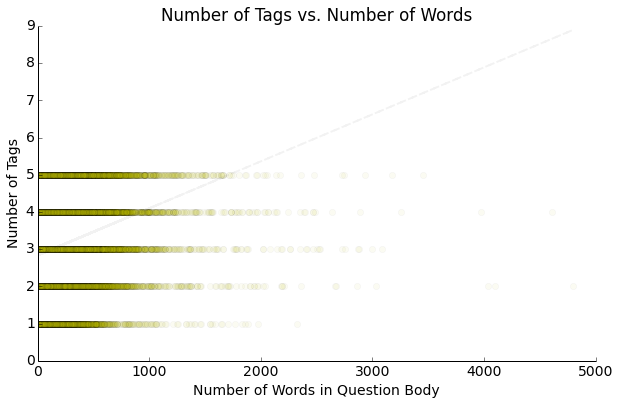

In [198]:
# correlation between number of tags and words in body
print questions[['n_Body', 'n_Tags']].corr()

# plot num tags vs. num words in body with best fit line
x = questions.n_Body
y = questions.n_Tags
fit = pyl.polyfit(x,y,1)
fit_fn = pyl.poly1d(fit)
pyl.plot(x,y, 'yo', x, fit_fn(x), '--k', alpha=.05)
pyl.ylim(0, pyl.ylim()[1])
pyl.xlim(0, pyl.xlim()[1])
plt.xlabel("Number of Words in Question Body")
plt.ylabel("Number of Tags")
plt.title("Number of Tags vs. Number of Words")
remove_border()

There is a low correlation between the number of tags and the words in the body so the length of the body will not be especially helfpul in predicting the number of tags.  Nonetheless, there is some trend here.

# Tag Prediction

We split the data downloaded into two sets, questions_training and questions_test (3/4 and 1/4 of the question set respectively)


In [5]:
#load training data
questions_train = pd.read_csv('questions_train.csv')
#filter out corrupted data
questions_train = questions_train[questions_train['Creation_date'] > 100]
questions_train = questions_train[~np.isnan(questions_train['Question_id'])]
questions_train = questions_train[~np.isnan(questions_train['User_id'])]
questions_train.reset_index(drop=True)
questions_train.head()

,Answer_count,Body,Creation_date,Is_answered,Link,Question_id,Score,Tags,Title,View_count,Reputation,User_id
0,0,<p>I have a number of PHP scripts that I am tr...,1386620377,False,http://stackoverflow.com/questions/20479918/de...,20479918,1,http asp-classic,Determining the length of a UTF-8 response in ...,9,3171,619852
1,0,<p>I seem to have hit a snag in my app that is...,1386649767,False,http://stackoverflow.com/questions/20486129/ha...,20486129,0,javascript meteor user-roles,Handlebars function causing tight loop in code,3,178,593622
2,1,<p>I'm having an issue installing zmap on Cent...,1386566071,False,http://stackoverflow.com/questions/20463635/zm...,20463635,0,make install centos,zmap Install Configuration Error,10,101,2518601
3,2,<p>The single tooltip which shows different me...,1386600912,False,http://stackoverflow.com/questions/20473604/to...,20473604,0,c# winforms tooltip,Tooltip background alternation,47,1,3070093
4,0,<p>I am getting these errors if the DbgHelp.h ...,1386649745,False,http://stackoverflow.com/questions/20486125/sy...,20486125,0,c++ objective-c,Syntax error in DbgHelp.h file,2,1,3085412


In [17]:
#load test data
questions_test = pd.read_csv('questions_test.csv')
#filter out corrupted data
questions_test = questions_test[questions_test['Creation_date'] > 100]
questions_test = questions_test[~np.isnan(questions_test['Question_id'])]
questions_test = questions_test[~np.isnan(questions_test['User_id'])]
questions_test.reset_index(drop=True)
questions_test.head()


,Answer_count,Body,Creation_date,Is_answered,Link,Question_id,Score,Tags,Title,View_count,Reputation,User_id
0,0,<p>I took a java class and a VB class this sem...,1386649804,FALSE,http://stackoverflow.com/questions/20486137/ho...,20486137,0,java,How do I learn to WRITE programs from scratch?,1,1,3085406
1,1,<p>Hello all I have a program that is dealing ...,1386649706,FALSE,http://stackoverflow.com/questions/20486115/ho...,20486115,0,python string,How do I delete the first part of a string in ...,8,43,2649920
2,5,<p>I tried using final keyword to array but st...,1386649500,TRUE,http://stackoverflow.com/questions/20486074/wh...,20486074,0,java,Why final is not applicable to array in Java?,26,1,2099274
3,0,<p>I have a application that fills in fields o...,1386649779,FALSE,http://stackoverflow.com/questions/20486133/dr...,20486133,0,c# image bitmap gdi,Draw large off screen form to bitmap,2,26,1137759
4,0,<p>I have a div with animation when you scroll...,1386649775,FALSE,http://stackoverflow.com/questions/20486131/ma...,20486131,0,javascript jquery jquery-ui,Make a Div to return to its original position ...,2,1,2879138


## Predicting Tags from Tags

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from itertools import combinations

A tag-to-tag recommender is the final step of the recommender system, however it is also the simplest: it uses tags alone to predict future tags. Once a user has seeded us with an initial tag, we can begin predicting what other tags they will use based on historical tag co-ocurrences. Our first attempt at recommending tags from tags is examines word co-occurences on a pair-wise basis. We start off by examining each inputted tag in isolation.

Methodology note: Because of the nature of a tag (some have punctuation), the usual CountVectorizer module does not effectively distinguish between tags. So we use the string "split" function instead. 

In [7]:
occur = defaultdict(lambda : defaultdict(int))
for item in questions_train.Tags.values:
    item = str(item)
    tags = item.split()
    for i in tags:
        for j in tags:
            occur[i][j] += 1
for k,v in occur.iteritems():
    v.pop(k)
    occur[k] = sorted(v.iteritems(), key=operator.itemgetter(1), reverse=True)
            

Now we have created dict of dicts $\verb|occur|$, which tells us how many entries have the tags specified by our two indices. We sort within each tag, so that $\verb|occur[tag]|$ tells us the most frequent tags first. Now, we write the function $\verb|recommend_tags|$ to give us the words that occur most frequently with the seeded tags. In this version, we are comparing raw numbers, which advantages tags that are more common in general over less common tags. 

In [8]:
def recommend_tags(already, num, occur):
    # check if a string was provided, or a list
    if not isinstance(already, list):
        already = already.split()
    possibletags = defaultdict(int)
    tags_nocount = []
    count = 0
    for item in already:
        for i in occur[item]:
            if i[0] in already:
                continue
            if possibletags[i[0]] == 0:
                count += 1
            possibletags[i[0]] += i[1]
            if count == num:
                break
    possibletags = sorted(possibletags.iteritems(), key=operator.itemgetter(1), reverse=True)
    return possibletags[:num]

recommend_tags(['ajax', 'php', 'html'], 10, occur)
        
        

[('javascript', 1872),
 ('css', 1458),
 ('jquery', 1426),
 ('mysql', 932),
 ('arrays', 323),
 ('forms', 296),
 ('codeigniter', 267),
 ('json', 236),
 ('wordpress', 225),
 ('asp.net', 220)]

Our function takes two parameters: a list of tags we have already inputed (this can be inputted as a list or as a string seperated by spaces, as provided in the file), and the number of tags it wants us to recommend. It generates recommendations by looking at the most frequent tags associated with each provided tag, if two provided tags point to the same tag, the scores are added together, and then the function returns the highest scoring tags. 

Because we did not normalize the co-occurence matrix, our recommender has a bias against less frequent tags. For example, suppose we provide tags X and Y. In general, 100% of the time that tag Y is used, tag Z is used, but tag Y is used very rarely to begin with. Tag X is a very common tag, and tag W occurs 50% of the time that tag X is used. Our recommender would probably prioritize W over Z for sufficiently small Y frequency, even though it is much more likely that tag Z will be used. The fact that Z is used very few times in absolute terms (even though it is used a lot in relative terms) makes it less likely to be chosen by our recommender. 

We modify with a slight change to our $\verb|occur|$ dict:

In [10]:
occur2 = defaultdict(lambda : defaultdict(int))
for item in questions_train.Tags.values:
    item = str(item)
    tags = item.split()
    for i in tags:
        for j in tags:
            occur2[i][j] += 1
for k,v in occur2.iteritems():
    cts = v.pop(k)
    # normalize
    for k2, v2 in v.iteritems():
        v[k2] = v2 * 1.0 / cts
    occur2[k] = sorted(v.iteritems(), key=operator.itemgetter(1), reverse=True)
            

In [11]:
recommend_tags(['ajax', 'php', 'html'], 10, occur2)

[('javascript', 0.6712034359422588),
 ('jquery', 0.6600073420154382),
 ('css', 0.3678725503381058),
 ('asp.net', 0.12396870571716562),
 ('mysql', 0.11767867714788188),
 ('json', 0.09646511052282328),
 ('jquery-ajax', 0.05900531379834119),
 ('forms', 0.05602329975810426),
 ('c#', 0.05563505886251597),
 ('java', 0.050755454930433375)]

The new, normalized vector gives us a rough probability that the user will use the tag supplied. The ordering of the list tells us that the new vector does indeed allow less common tags to bubble up: jquery is used more often with ajax then css is with html. So even though css is used more often, we know that our user is more likely to pick jquery, and our recommender puts that first. 

But we can still do better. Considering each supplied tag in isolation is not ideal; the reality is that the tags together tell us a story. While perhaps "ajax" is commonly used with "asp.net," the presence of "php" tells us that maybe "asp.net" isn't of interest after all -- our user has already identified a different web language. How can we take the tags into consideration as a group?

Our old structure only tells us about pair-wise relationships: this doesn't scale well when we want to know how a few tags work together. We restructure our data by creating a dict and a list. Our dict will tell us what entries a tag is in. The list helps us identify the other words used in an entry. 

In [12]:
# create entry-word mappings
to_id = defaultdict(list)
from_id = []
for item in questions_train.Tags.values:
    item = str(item)
    tags = item.split()
    index = len(from_id)
    from_id.append(tags)
    for i in tags:
        to_id[i].append(index)

We now have a better foundation for examining tag groups. Now, we create a new function to examine these groups.

The ideal is to find other entries that use *all* of the tags supplied. Someone else tagged "php" AND "ajax" AND "html"? Great! Tell us what else they used. If we can't find any such entry, then the next best thing is to look at pairs: entries that used "php" and "ajax," or "php" and "html." If all else fails, we fall back on examining each tag in isolation. 

In [13]:
def recommend_tags_merge(already, num):
    if not isinstance(already, list):
        already = already.split()
    possibletags = defaultdict(lambda: defaultdict(int))
    tags_nocount = [] # list of all tags accessed 
    n = len(already) # number of tags we've been supplied with
    used = [] # entries we've examined already
    words = 0 # number of tags collected
    # for every length l
    for l in range(n, 1, -1):
        # for every subset of length l
        for c in combinations(already, l):
            # find the entries that use all the tags in our subset
            indices = set(to_id[c[0]])
            for tag in c[1:]:
                indices = indices.intersection(to_id[tag])
            # if there are entries that use all the tags in our subset
            if len(indices) > 0:
                for entry in indices:
                    # make sure we don't double count
                    if entry not in used:
                        for tag in from_id[entry]:
                            # track frequencies weighted by number of tags present
                            # the weighting is not necessary, but helps us prioritize tags that occur with more supplied tags
                            if tag not in already and tag not in tags_nocount:
                                possibletags[l][tag] += 1*l
                        # mark entry used
                        used.append(entry)
        # don't look at the new tags we just added anymore
        for tag in possibletags[l]:
            tags_nocount.append(tag)
        words += len(possibletags[l])
        # we have enough tags, no need to search further
        if words >= num:
            break
    else:
        # worst case scenario: we try our old method
        lasttry = recommend_tags(already, num, occur2)
        #for tuples in lasttry:
        #    if tuples[0] not in tags_nocount:
        #        possibletags[1][tuples[0]] = tuples[1]
    tagbag = []
    # start with the tags that ocurred with the highest number of supplied tags
    if n > 1:
        for i in range(n, l-1, -1):
            # sort within the subset size
            a = sorted(possibletags[i].iteritems(), key=operator.itemgetter(1), reverse=True)
            for item in a:
                tagbag.append(item)
    # make up for the difference if we hit our worst case scenario
    if len(tagbag) < num:
        diff = num - len(tagbag)
        tagbag.append(lasttry[:diff])
        
    return tagbag[:num]

In [14]:
print recommend_tags_merge('php ajax html', 10)


[('javascript', 21), ('jquery', 9), ('forms', 6), ('payment-gateway', 3), ('internet-explorer', 3), ('api', 3), ('mysql', 3), ('jqtransform', 3), ('web-applications', 3), ('css', 70)]


Our new recommender is a huge improvement. It weeded out tags we would never use: "asp.net", "post" ,"c#": it successfully recognized that we're not going to program with asp.net or c# if we're using php, and we're probably not worried about c# if we're using html. The tags supplied are concepts that realistically would come up in a situation in which php, ajax, and html are all being used. Note that the scores are not in descending order: this is because we prioritize the tags that occur with the largest subset of supplied tags (in this case, all three tags) over tags that occur with a smaller subset (in this case, two of the three tags), even though the smaller subset has tags that are more frequent. Although those tags are more frequent, they are less relevant to all three tags and therefore less important. 

To determine the effectiveness of the recommender in practice, we test how accurately it predicts tags. To do so, we will look at the tags for each entry in our data set. Use the first few supplied tags to test, and see if our recommenders give us the last supplied tag. For example, if the tags are 'x y z a', then we want 'x y z' to predict 'a'.

In [18]:
num = 0
num2 = 0
num3 = 0
num4 = 0
den = 0
for item in questions_test.Tags.values:
    item = str(item)
    tags = item.split()
    if isinstance(tags, list) and len(tags) > 2:
        go = True
        for word in tags:
            if len(to_id[word]) < 25:
                go = False
        if go == False:
            continue
        try:
            result = recommend_tags_merge(tags[:-1], 10)
            result = [t[0] for t in result]
            result2 = recommend_tags(tags[:-1], 10, occur)
            result2 = [t[0] for t in result2]
            result3 = recommend_tags(tags[:-1], 10, occur2)
            result3 = [t[0] for t in result3]
        except IndexError:
            print item
            continue
        if len(result3) == 10:
            if tags[-1] in result:
                num += 1
            if tags[-1] == result[0]:
                num2 += 1
            if tags[-1] in result2:
                num3 += 1
            if tags[-1] in result3:
                num4 += 1
            den += 1
        else:
            print 1
            
print "***TEST DATA**"
print "Tag Merged Recommender", num * 1.0 / den
#print "num2 * 1.0 / den, 
print "Single-Tag Recommender", num3 * 1.0/den
print "Single-Tag Recommender, Normalized", num4*1.0/den

nump = 0
nump2 = 0
nump3 = 0
nump4 = 0
denp = 0
for item in questions_train.Tags.values:
    item = str(item)
    tags = item.split()
    if isinstance(tags, list) and len(tags) > 2:
        go = True
        for word in tags:
            if len(to_id[word]) < 25:
                go = False
        if go == False:
            continue
        try:
            result = recommend_tags_merge(tags[:-1], 10)
            result = [t[0] for t in result]
            result2 = recommend_tags(tags[:-1], 10, occur)
            result2 = [t[0] for t in result2]
            result3 = recommend_tags(tags[:-1], 10, occur2)
            result3 = [t[0] for t in result3]
        except IndexError:
            print item
            continue
        if len(result3) == 10:
            if tags[-1] in result:
                nump += 1
            if tags[-1] == result[0]:
                nump2 += 1
            if tags[-1] in result2:
                nump3 += 1
            if tags[-1] in result3:
                nump4 += 1
            denp += 1
        else:
            print 1
            
print "***TRAIN DATA**"
print "Tag Merged Recommender",  nump * 1.0 / denp
#print "num2 * 1.0 / den, 
print "Single-Tag Recommender", nump3 * 1.0/denp
print "Single-Tag Recommender, Normalized", nump4*1.0/denp
        
        
        

***TEST DATA**
Tag Merged Recommender 0.292255717256
Single-Tag Recommender 0.135031185031
Single-Tag Recommender, Normalized 0.206600831601
***TRAIN DATA**
Tag Merged Recommender 0.72860993454
Single-Tag Recommender 0.132409190091
Single-Tag Recommender, Normalized 0.215299704788


We mitigated much of the overfit in our data by limiting our analysis to tags that occur at least 25 times in our data set. Still, there is an overfit issue as there is a dramatic difference between train and test data with our merge recommender. This is because most tag groupings are unique to the training data, consequently they are not as useful in the test data. Considering we are only using tag data without context, 30% accuracy with our best recommender is pretty good. Now, we incorporate more data. 

## Bag of Words and Classifiers

We have used scikit-learn to predict the tags from text through a bag-of-words approach. Due to the large scope of our data, we have utilized sparse matrices to store different features and have run the data through various classifiers. 

In [22]:
# Libraries to Import

import re
from operator import itemgetter

# SKLearn 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split


# Classifiers
from sklearn.naive_bayes import MultinomialNB

### Preparing the Data

We will be working with the questions.csv data set but must conduct some modifications to the set first to allow efficient processing. 

First, we will simply grab the first 10,000 lines from the frame.

In [23]:
# grab first 10,000 lines from questions data frame, which is already sorted
questions = questions.iloc[0:9999,:]
questions['Title'] = questions['Title'].apply(lambda s: re.sub(r'([^\s\w]|_)+', '',s))

#### Filtering Out Common Words

Stop words are words such as "the" and "about" that are commonly used but have very little predictive power. To support efficient text processing, we will filter out these words before the processing of our data. 

In [24]:
# List of stop words
stop = "a's able about above according accordingly across actually after afterwards again against ain't all allow allows almost alone along already also although always am among amongst an and another any anybody anyhow anyone anything anyway anyways anywhere apart appear appreciate appropriate are aren't around as aside ask asking associated at available away awfully be became because become becomes becoming been before beforehand behind being believe below beside besides best better between beyond both brief but by c'mon c's came can can't cannot cant cause causes certain certainly changes clearly co com come comes concerning consequently consider considering contain containing contains corresponding could couldn't course currently definitely described despite did didn't different do does doesn't doing don't done down downwards during each edu eg eight either else elsewhere enough entirely especially et etc even ever every everybody everyone everything everywhere ex exactly example except far few fifth first five followed following follows for former formerly forth four from further furthermore get gets getting given gives go goes going gone got gotten greetings had hadn't happens hardly has hasn't have haven't having he he's hello help hence her here here's hereafter hereby herein hereupon hers herself hi him himself his hither hopefully how howbeit however i'd i'll i'm i've  if ignored immediate in inasmuch inc indeed indicate indicated indicates inner insofar instead into inward is isn't it it'd it'll it's its itself just keep keeps kept know known knows last lately later latter latterly least less lest let let's like liked likely little look looking looks ltd mainly many may maybe me mean meanwhile merely might more moreover most mostly much must my myself name namely nd near nearly necessary need needs neither never nevertheless new next nine no nobody non none noone nor normally not nothing novel now nowhere obviously of off often oh ok okay old on once one ones only onto or other others otherwise ought our ours ourselves out outside over overall own particular particularly per perhaps placed please plus possible presumably probably provides que quite qv rather rd re really reasonably regarding regardless regards relatively respectively right said same saw say saying says second secondly see seeing seem seemed seeming seems seen self selves sensible sent serious seriously seven several shall she should shouldn't since six so some somebody somehow someone something sometime sometimes somewhat somewhere soon sorry specified specify specifying still sub such sup sure t's take taken tell tends th than thank thanks thanx that that's thats the their theirs them themselves then thence there there's thereafter thereby therefore therein theres thereupon these they they'd they'll they're they've think third this thorough thoroughly those though three through throughout thru thus to together too took toward towards tried tries truly try trying twice two un under unfortunately unless unlikely until unto up upon us use used useful uses using usually value various very via viz vs want wants was wasn't way we we'd we'll we're we've welcome well went were weren't what what's whatever when whence whenever where where's whereafter whereas whereby wherein whereupon wherever whether which while whither who who's whoever whole whom whose why will willing wish with within without won't wonder would wouldn't yes yet you you'd you'll you're you've your yours yourself yourselves zero".split( )

def remove_stop_words(line, stop):
    # make lowercase for uniformity
    line = line.lower() 
    # remove each of the stop words from the given line
    for w in stop:
        line = re.sub(r'\b%s\b' % w, '', line)  # '\b' is a word boundry
    return line

# remove stop words from the title
questions['Clean_Title'] = questions['Title'].apply(lambda s: remove_stop_words(s,stop))

#### Acquiring Most Common Tags

Due to the large number of tags present within this dataset, we will not be working with all of them. Above, we have shown that the top 100 most common tags account for approximately 40% of all tag occurences within the dataset. We will limit our prediction of tags to these top 100 to check our model's predictive power.

In [4]:
# Most Common Tags


"""
Function
--------
count_words

Counts tag occurences

Parameters
-----------
series : Pandas Series
    Series of tags
    
Returns
-------
n_tags : dictionary 
    Gives counts for each of the tags
"""
# count tag occurrences
def count_words(series):
    n_tags = {}
    for tags in series:
        tags = tags.split()
        for tag in tags:
            tag = tag.lower()
            if tag in n_tags:
                n_tags[tag] += 1
            else:
                n_tags[tag] = 1
    return n_tags

# most common words in series
n_tags = (count_words(questions.Tags))
sorted_n_tags = sorted(n_tags.iteritems(), key=itemgetter(1), reverse=True)
data = sorted_n_tags[:100]

# format data without commas or brackets
top_100 = [x[0] for x in data]
top_100 = [x.strip().strip("[],") for x in top_100]

print "100 Most Common Tags:"
print
print (top_100)


100 Most Common Tags:

['android', 'javascript', 'java', 'php', 'ios', 'c#', 'jquery', 'python', 'html', 'ios7', 'c++', 'objective-c', 'ruby-on-rails', 'css', 'sql', 'mysql', 'ruby', 'iphone', 'asp.net', 'angularjs', 'c', 'eclipse', '.net', 'asp.net-mvc', 'twitter-bootstrap', 'xcode', 'node.js', 'postgresql', 'osx', 'json', 'html5', 'google-maps', 'ajax', 'linux', 'cordova', 'django', 'windows', 'facebook', 'sql-server', 'wordpress', 'arrays', 'database', 'xml', 'spring', 'asp.net-mvc-4', 'apache', 'ruby-on-rails-4', 'xcode5', 'excel', 'forms', 'r', 'rails-postgresql', 'regex', 'image', 'matlab', 'google-chrome', 'vb.net', 'visual-studio-2012', 'multithreading', 'uitableview', 'hibernate', 'string', 'file', 'windows-phone-8', 'algorithm', 'twitter-bootstrap-3', 'mongodb', 'git', 'maven', 'google-app-engine', 'entity-framework', 'css3', 'winforms', 'osx-mavericks', 'scala', 'visual-studio', 'api', 'internet-explorer', 'ubuntu', 'symfony2', 'visual-studio-2013', 'email', 'facebook-graph-

We finally create a dataframe containing the question titles and tag occurrences for the top 100 tags. We filter out the questions that do not have tags in the top 100. This is so our classifiers can learn on the relevant data. This will definitely introduce bias within our model because the test set will only involve data that may have a common tag word. However, for computational reasons, we are maintaining this choice; our model can be easily extended to cover the full data set with all of the possible tags.

In [32]:
# initialize dataframe with the question title and the cleaned question title
question_frame = pd.DataFrame(questions.Title)
question_frame['Clean_Title'] = questions['Clean_Title']

# make Y vector, indicating whether or not tag shows up in question (for all tags)
tags = [tag.split() for tag in list(questions.Tags)]
for top in top_100:
    words = [1 if top in word else 0 for word in tags]
    question_frame[top] = words

# filter out questions that do not have tags in the top 100
Top = []
for tag in tags:
    b1 = tag
    b2 = top_100
    b3 = set(b1).intersection( set(b2) ) != set([])
    Top.append(b3)

question_frame['Top'] = Top
question_frame = question_frame[question_frame.Top != False]
question_frame = question_frame.drop('Top',1)

As an illustration, here is the second row of the dataframe. The printout includes the question title, the cleaned question title, and binary values indicating whether or not a specific tag is associated with the question. The dataframe has 102 columns correspnding to the title, cleaned title, and all of the top 100 tags. The dataframe now has 8,114 rows, where each row corresponds to a question.

In [33]:
print "Shape of DataFrame"
print question_frame.shape
print question_frame
print
print "Second row of DataFrame"
print
print question_frame.irow(2)

Shape of DataFrame
(8114, 102)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8114 entries, 0 to 10018
Columns: 102 entries, Title to validation
dtypes: int64(100), object(2)

Second row of DataFrame

Title            Why final is not applicable to array in Java
Clean_Title                   final   applicable  array  java
android                                                     0
javascript                                                  0
java                                                        1
php                                                         0
ios                                                         0
c#                                                          0
jquery                                                      0
python                                                      0
html                                                        0
ios7                                                        0
c++                                                 

### Building Our Model

We use a Naive Bayes classifier to build a prediction model for whether a specific tag from the top 100 will be associated with a Stack Overflow question, depending on the title of the question. 

Most models work with numerical data, so we need to convert the textual collection of questions to something numerical. A common strategy for text classification is to represent each review as a "bag of words" vector -- a long vector of numbers encoding how many times a particular word appears in a blurb.

In [34]:


"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
question_frame : Pandas DataFrame
    The question data from above
    
tag_id : integer
    A number relating to the tag (out of the 
    top 100) that should be used. It also 
    corresponds to the column within the 
    question_frame dataframe.
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the question data
    
Returns
-------
X : numpy array (dims: nquestions, nwords)
    Bag-of-words representation for each question.
Y : numpy array (dims: nquestions)
    1/0 array. 1 = tag present, 0 = tag absent
title : numpy array (dims: nquestions)
    1/0 array. 1 = tag present, 0 = tag absent

Examples
--------
X, Y, title = make_xy(question_frame,5)
"""

def make_xy(question_frame, tag_id, vectorizer=None):
    # default is Count Vectorizer
    if vectorizer is None:
        vectorizer = CountVectorizer()
    title = question_frame.Title
    
    # bag of words transformation
    X = vectorizer.fit_transform(question_frame.Clean_Title)
    X = X.tocsc()  # some versions of sklearn return COO format
    
    # 1/0 array relating to specific tag word
    Y = (question_frame.iloc[:,tag_id]).values
    
    return X,Y,title

Scikit-learn has an object called a CountVectorizer that turns text into a bag of words. It does this by converting the collection of text to a matrix of token counts. We can also do the same thing using a TFID vectorizer, which is equivalent to using a CountVectorizer followed by TfidfTransformer (for normalization). The raw text are transformed to tf–idf vectors

In [35]:
# Example using the TfidfVectorizer for one of the tags
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
print "Extracting features using a sparse vectorizer"
X,Y,title = make_xy(question_frame,3,vectorizer)
X_train, X_test, y_trains, y_tests, title_train, title_test = train_test_split(X, Y, title, test_size=0.33)
y_train =y_trains
y_test = y_tests


print "TRAINING: n_samples: %d, n_features: %d" % X_train.shape
print "TEST: n_samples: %d, n_features: %d" % X_test.shape

vocabulary = np.array([t for t, i in sorted(vectorizer.vocabulary_.iteritems(),
                                            key=itemgetter(1))])


Extracting features using a sparse vectorizer
TRAINING: n_samples: 5436, n_features: 9754
TEST: n_samples: 2678, n_features: 9754


#### Learning with the Classifier

First, we build a benchmark classifier function that will apply the classifier to training and test data

In [36]:
"""
Function
--------
classifier

Apply a classifier to training and test data

Parameters
-----------
clf : function
    Specific classifier to be used
    
tag_id : integer
    A number relating to the tag (out of the 
    top 100) that should be used. It also 
    corresponds to the column within the 
    question_frame dataframe.
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the question data
    
Returns
-------
X : numpy array (dims: nquestions, nwords)
    Bag-of-words representation for each question.
Y : numpy array (dims: nquestions)
    1/0 array. 1 = tag present, 0 = tag absent
title : numpy array (dims: nquestions)
    1/0 array. 1 = tag present, 0 = tag absent

Examples
--------
X, Y, title = make_xy(question_frame,5)
"""
# classifiers

def classifier(clf_id,X_train,X_test,y_train,y_rest, prints=True):
    if clf_id == 1:
        clf = MultinomialNB()
    elif clf_id == 2:
        clf = KNeighborsClassifier(n_neighbors=7)
    elif clf_id == 3:
        clf = SGDClassifier(loss="log", penalty="l2")
    
    if prints == True:
        print "Training: "
        print clf
    clf.fit(X_train, y_train)
    
    if prints==True:
        print "Predictions on Test"
    pred = clf.predict(X_test)
    if prints==True:
        print pred
    
    score = 100 * clf.score(X_test, y_test)
    #score = metrics.f1_score(y_test, pred)
    if prints==True:
        print "Prediction Right: %0.2f%%" % (score)
        
    # Probability    
    if clf_id == 1:
        #probs = clf.predict_proba(X_test)[:,1]
        probs = clf.predict_log_proba(X_test)[:, 1]
    else:
        probs = clf.predict_proba(X_test)[:, 0]
    

    return probs

We can see this classifier function in action when applied with different scikit-learn classifiers. The percentages of right predictions outputted gives a measure of how good the model is at predicting whether or not a specific tag word appeared for a question. 

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB


results=[]
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
X,Y, title = make_xy(question_frame,101,vectorizer)
split_ind = X_train.shape[0]
X_train, X_test, y_trains, y_tests, title_train, title_test = train_test_split(X, Y, title, test_size=0.33)
X_train, X_test, y_trains, y_tests, title_train, title_test = X[:split_ind], X[split_ind:], Y[:split_ind], Y[split_ind:], title[:split_ind], title[split_ind:]


for clf, name in (
        (1, "Naive Bayes"),
        (2, "kNN"),
        ):
    print('=' * 80)
    print(name)
    results.append(classifier(clf,X_train,X_test, y_train,y_test))


Naive Bayes
Training: 
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Predictions on Test
[0 0 0 ..., 0 0 0]
Prediction Right: 88.50%
kNN
Training: 
KNeighborsClassifier(algorithm=auto, leaf_size=30, metric=minkowski,
           n_neighbors=7, p=2, weights=uniform)
Predictions on Test
[0 0 0 ..., 0 0 0]
Prediction Right: 88.27%


We can see that the prediction percentages are very inflated because most of the 100 tags observed  do not appear in the list of tags for a given question. Therefore, the classifiers correctly predict most of the time that a certain tag does not appear within the feature list.

### Extracting Predictions from the Classifiers

In this section, we will use teh above functions to actually apply the classifiers to our model to get tag predictions.

#### Naive Bayes Classifier

In [14]:
# Get tag probalities for each question using Naive Bayes
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
probs = np.empty([y_test.shape[0],1])
for i in range(2, 101):
    X,Y,title = make_xy(question_frame,i,vectorizer)
    
    # We split the data at the same index utilized above from the train_test_split function. 
    # However, to remove the arbitrariness of the split, we will hard-code the split-index
    # instead of re-splitting each time
    X_train, X_test, y_train, y_test, title_train, title_test = X[:split_ind], X[split_ind:], Y[:split_ind], Y[split_ind:], title[:split_ind], title[split_ind:]
    clf = 1 # corresponds to MultinomialNB()
    proba = classifier(clf,X_train,X_test,y_train,y_test, prints=False)
    probs = np.column_stack((probs, proba)) 
probs = probs[:,1:]

# output probabilities
print probs



[[-3.23973205 -2.95362989 -4.06540057 ..., -7.11489229 -7.11063735
  -7.50530111]
 [-2.63756421 -3.0336707  -1.38640445 ..., -5.94086444 -5.75416869
  -6.16848655]
 [-3.18642734 -3.94279582 -2.73649785 ..., -7.05528708 -6.99032289
  -7.28263862]
 ..., 
 [-4.24258575 -4.18008344 -4.46042461 ..., -9.65206198 -9.60738482
  -9.70211904]
 [-2.75574377 -3.51094282 -2.06764976 ..., -6.34952459 -6.28438962
  -6.5773041 ]
 [-1.99759937 -1.58704926 -2.34792227 ..., -5.31939706 -5.25447122
  -5.54654218]]


The probabilities outputted correspond to the probability of the ith tag being in the tag_list for each question for each of the questions.

In [782]:
# dictionary of top 5 tags per question title
tags_dict = {}
lentest = len(y_test)
Y = (question_frame.iloc[:,2:]).values
for i in range(0, lentest):
    ind = np.argsort(probs[i])
    ind2 = np.argsort(Y[i])
    words = [top_100[n] for n in ind]
    words2 = [top_100[n] for n in ind2]
    top_5 = words[-5:]
    top_5_true = words2[-5:]
    tags_dict.update({title_test.values[i]:{'pred': top_5, 'true' : top_5_true}})


# Print the first 5
five_keys = tags_dict.keys()[:5]
five_vals = tags_dict.values()[:5]

for x in xrange(5):
    print five_keys[x]
    print five_vals[x]
    print




Minor image editing functionality alongside AngularJS
{'pred': ['c#', 'php', 'java', 'android', 'javascript'], 'true': ['postgresql', 'facebook', 'cordova', 'javascript', 'android']}

Using Kendo Grid with Server Side Filters and Server Side Sorting Field  NULL
{'pred': ['jquery', 'c#', 'android', 'javascript', 'java'], 'true': ['osx', 'postgresql', 'node.js', 'windows', 'excel']}

CSS 3 Level Dropdown Menu
{'pred': ['java', 'css', 'android', 'jquery', 'javascript'], 'true': ['postgresql', 'node.js', 'django', 'validation', 'entity-framework']}

How do I get an ECDSA public key from just a Bitcoin signature  SEC1 416 key recovery for curves over mod pfields
{'pred': ['c#', 'php', 'android', 'javascript', 'java'], 'true': ['osx', 'postgresql', 'facebook', 'validation', 'python']}

AngularJS  handle routing before they load
{'pred': ['ios', 'javascript', 'php', 'java', 'android'], 'true': ['osx', 'postgresql', 'windows', 'validation', '.net']}



Get Accuracy:

In [783]:
cnt_correct = 0
for k,v in tags_dict.iteritems():
    if len(set(v['pred']).intersection(set(v['true']))) >= 1:
        cnt_correct += 1
accuracy =  cnt_correct * 100.0 / len(tags_dict)

print "Accuracy of Naive Bayes Classifier: %0.2f%%" % (accuracy)

Accuracy of Naive Bayes Classifier: 42.76%


#### KNN Nearest Neighbors Classifier

We will also try applying a kNN classifier to our data to see if this will increase performance. 

In [28]:
X,Y, title = make_xy(question_frame,101,vectorizer)
split_ind = X_train.shape[0]

# Get tag probalities for each question using KNearest Neighbors
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
probs = np.empty([y_test.shape[0],1])
for i in range(2, 101):
    X,Y,title = make_xy(question_frame,i,vectorizer)
    
    # We split the data at the same index utilized above from the train_test_split function. 
    # However, to remove the arbitrariness of the split, we will hard-code the split-index
    # instead of re-splitting each time
    X_train, X_test, y_train, y_test, title_train, title_test = X[:split_ind], X[split_ind:], Y[:split_ind], Y[split_ind:], title[:split_ind], title[split_ind:]
    clf = 2 # corresponds to kNN
    proba = classifier(clf,X_train,X_test,y_train,y_test, prints=False)
    probs = np.column_stack((probs, proba)) 
probs = probs[:,1:]

# output probabilities
print probs

[[ 1.          1.          0.42857143 ...,  1.          1.          1.        ]
 [ 1.          0.71428571  0.85714286 ...,  1.          1.          1.        ]
 [ 0.71428571  1.          0.57142857 ...,  1.          1.          1.        ]
 ..., 
 [ 0.85714286  1.          0.85714286 ...,  1.          1.          1.        ]
 [ 0.85714286  1.          0.71428571 ...,  1.          1.          1.        ]
 [ 0.85714286  1.          1.         ...,  1.          1.          1.        ]]


In [29]:
# dictionary of top 5 tags per question title

tags_dict = {}
lentest = len(y_test)
Y = (question_frame.iloc[:,2:]).values
for i in range(0, lentest):
    ind = np.argsort(probs[i])
    ind2 = np.argsort(Y[i])
    words = [top_100[n] for n in ind]
    words2 = [top_100[n] for n in ind2]
    top_5 = words[-5:]
    top_5_true = words2[-5:]
    tags_dict.update({title_test.values[i]:{'pred': top_5, 'true' : top_5_true}})
  

# Print the first 5
five_keys = tags_dict.keys()[:5]
five_vals = tags_dict.values()[:5]

for x in xrange(5):
    print five_keys[x]
    print five_vals[x]
    print

Minor image editing functionality alongside AngularJS
{'pred': ['google-maps', 'html5', 'json', 'wordpress', 'python-2.7'], 'true': ['postgresql', 'facebook', 'cordova', 'javascript', 'android']}

Using Kendo Grid with Server Side Filters and Server Side Sorting Field  NULL
{'pred': ['google-maps', 'json', 'osx', 'wordpress', 'python-2.7'], 'true': ['osx', 'postgresql', 'node.js', 'windows', 'excel']}

CSS 3 Level Dropdown Menu
{'pred': ['linux', 'ajax', 'google-maps', 'json', 'python-2.7'], 'true': ['postgresql', 'node.js', 'django', 'validation', 'entity-framework']}

How do I get an ECDSA public key from just a Bitcoin signature  SEC1 416 key recovery for curves over mod pfields
{'pred': ['linux', 'ajax', 'google-maps', 'arrays', 'python-2.7'], 'true': ['osx', 'postgresql', 'facebook', 'validation', 'python']}

AngularJS  handle routing before they load
{'pred': ['html5', 'json', 'osx', 'facebook', 'python-2.7'], 'true': ['osx', 'postgresql', 'windows', 'validation', '.net']}



Get Accuracy

In [30]:
cnt_correct = 0
for k,v in tags_dict.iteritems():
    if len(set(v['pred']).intersection(set(v['true']))) >= 1:
        cnt_correct += 1
accuracy =  cnt_correct * 100.0 / len(tags_dict)

print "Accuracy of KNN Classifier: %0.2f%%" % (accuracy)

Accuracy of KNN Classifier: 29.15%


### Limitations

Overall, the Naive Bayes Classifier performs better than kNN with an accuracy above 40%. 
However, we should note some of the limitations of our model in general.

 * Bag of Words assumes ordering of words not important
 * Data set only includes questions that have at least one tag in top 100
 * Standard defaults for each of the classifiers is used. Further explorations can delve into the specific optimizing parameters
 


## Graphical Model Tag Prediction

To predict tags for stackoverflow questions, we first take the question titles and tags of the training set to construct a weighted directed graph with self loops. We outline our steps below:

* Filter out stopwords and numbers from the question title
* For each word in the question title construct a node if no such node exist
* For each word in the question title, construct an edge from the word to each tag for the question, set the weight = 1. If such edge already exist, increment edge weight by 1
* Add another field to each edge called 'percent'. For edge[x][y], percent is defined as  edge[x][y]['weight'] divided by the total weight of edges from x. Note that we use 'percent' as a measure here because we wanted to give nodes that are less popular (ie matlab) and nodes with much more popularity (ie java) equal weighing in our prediction function

In [19]:
import itertools
import networkx as nx
import operator

stopwords = "a's able about above according accordingly across actually after afterwards again against ain't all allow allows almost alone along already also although always am among amongst an and another any anybody anyhow anyone anything anyway anyways anywhere apart appear appreciate appropriate are aren't around as aside ask asking associated at available away awfully be became because become becomes becoming been before beforehand behind being believe below beside besides best better between beyond both brief but by c'mon c's came can can't cannot cant cause causes certain certainly changes clearly co com come comes concerning consequently consider considering contain containing contains corresponding could couldn't course currently definitely described despite did didn't different do does doesn't doing don't done down downwards during each edu eg eight either else elsewhere enough entirely especially et etc even ever every everybody everyone everything everywhere ex exactly example except far few fifth first five followed following follows for former formerly forth four from further furthermore get gets getting given gives go goes going gone got gotten greetings had hadn't happens hardly has hasn't have haven't having he he's hello help hence her here here's hereafter hereby herein hereupon hers herself hi him himself his hither hopefully how howbeit however i'd i'll i'm i've  if ignored immediate in inasmuch inc indeed indicate indicated indicates inner insofar instead into inward is isn't it it'd it'll it's its itself just keep keeps kept know known knows last lately later latter latterly least less lest let let's like liked likely little look looking looks ltd mainly many may maybe me mean meanwhile merely might more moreover most mostly much must my myself name namely nd near nearly necessary need needs neither never nevertheless new next nine no nobody non none noone nor normally not nothing novel now nowhere obviously of off often oh ok okay old on once one ones only onto or other others otherwise ought our ours ourselves out outside over overall own particular particularly per perhaps placed please plus possible presumably probably provides que quite qv rather rd re really reasonably regarding regardless regards relatively respectively right said same saw say saying says second secondly see seeing seem seemed seeming seems seen self selves sensible sent serious seriously seven several shall she should shouldn't since six so some somebody somehow someone something sometime sometimes somewhat somewhere soon sorry specified specify specifying still sub such sup sure t's take taken tell tends th than thank thanks thanx that that's thats the their theirs them themselves then thence there there's thereafter thereby therefore therein theres thereupon these they they'd they'll they're they've think third this thorough thoroughly those though three through throughout thru thus to together too took toward towards tried tries truly try trying twice two un under unfortunately unless unlikely until unto up upon us use used useful uses using usually value various very via viz vs want wants was wasn't way we we'd we'll we're we've welcome well went were weren't what what's whatever when whence whenever where where's whereafter whereas whereby wherein whereupon wherever whether which while whither who who's whoever whole whom whose why will willing wish with within without won't wonder would wouldn't yes yet you you'd you'll you're you've your yours yourself yourselves zero".split( )

"""
Function
--------
questions_graph(titles, tags,stopwords)
  make a weighted DiGraph for question titles nad tags

Parameters
----------
titles : list of strings
  question titles

tags: list of strings
  actual tags used
  
stopwords: list of strings
  noise words we want to filter out
  
Returns
--------
A weighted DiGraph 
"""

def questions_graph(titles, tags,stopwords):
    G=nx.DiGraph() 
    for idx, title in enumerate(titles):
        tag_list = tags[idx].split( )
        title_list = title.split( )
        for i in title_list:
            if i not in stopwords and not i.isdigit():
                NN = str(i)
                #check nodes
                if not G.has_node(NN):
                    G.add_node(NN)
                for j in tag_list:
                    NNT = str(j)
                    #check edges
                    if G.has_edge(NN, NNT):
                        # we added this one before, just increase the weight by one
                        G[NN][NNT]['weight'] += 1
                    else:
                        G.add_edge(NN, NNT, weight=1, percent = 0)
    #compute difference
    for i in G.nodes():
        total = 0
        for j in G[i].iteritems():
            total = total + j[1]['weight']
        counter = 0
        for k in sorted(G[i].iteritems(), key=operator.itemgetter(1),reverse=True): #G[i].iteritems()
            counter = counter +1 
            # only keep top 20 for a word 
            if counter > 20:
                G.remove_edge(i,k[0])
            else: 
                G[i][k[0]]['percent'] = G[i][k[0]]['weight']/ float(total) 
    return G

titles_train = np.array(questions_train['Title'])
tags_train = np.array(questions_train['Tags'])
graph = questions_graph(titles_train, tags_train,stopwords)

To predict tags for the test set, for each word in the tag set, we first check if it is in the graph. If it is, then we look at its 20 highest 'percent' edges to find the most closely related tags. Then we combine all these words in a large array (if a tag appears twice, we simply add the 'percent'). Then we sort the big array to figure out the top 5 tags by percent.

In [20]:
"""
Function
--------
make_predictions(titles,stopwords,graph)
  make predictions for tags based on our graph

Parameters
----------
titles : list of strings
  question titles

stopwords: list of strings
  noise words we want to filter out
  
graph: Networkx DiGraph
  weighted graph of words and tags
  
Returns
--------
A List of Predictions
  For each question, our top 5 predicted tags 
"""

def make_predictions(titles,stopwords,graph):
    predictions = []
    for idx, title in enumerate(titles):
        title_list = title.split( )
        top = dict()
        for i in title_list:
            if graph.has_node(i):
                for j in graph[i].iteritems():
                    istr = str(j[0])
                    if istr in top.keys():
                        top[istr] = top[istr] + j[1]['percent']
                    else:
                        top[istr] = j[1]['percent']
        sorted_all = sorted(top.iteritems(), key=operator.itemgetter(1),reverse=True)
        sorted_top_5 = sorted_all[:5]
        predictions.append(sorted_top_5)
    return predictions

titles = np.array(questions_test['Title'])
predictions = make_predictions(titles,stopwords,graph)


Here is a sample prediction:

In [23]:
num = 3
print "title of question:", titles[num] 
print "our prediction: ", [i[0] for i in predictions[num]]
tags = np.array(questions_test['Tags'])
print "actual time: ", tags[num].split( )

title of question: Draw large off screen form to bitmap
our prediction:  ['android', 'c#', 'bitmap', 'javascript', 'java']
actual time:  ['c#', 'image', 'bitmap', 'gdi']


In [24]:
"""
Function
--------
calc_acurracy(predictions, tags)
  calculate the accuracy of our predictions compared to actual tags

Parameters
----------
predictions : list of tuples
  predictions of our model

tags: list of strings
  actual tags used
  
Returns
--------
A List of Success Percentages
  For each question, the % of tags we predicted correctly
"""

def calc_acurracy(predictions, tags):
    percent_success = []
    for idx, prediction in enumerate(predictions):
        prediction = [i[0] for i in prediction]
        tag = tags[idx].split( )
        numtag = len(tag)
        common = set(tag) & set(prediction)
        numcommon = len(common)
        percent_success.append(numcommon / float(numtag))
    return percent_success

tags = np.array(questions_test['Tags'])
percent_success = calc_acurracy(predictions, tags)

total number of questions in test set:  63521
number of questions with at least 1 tag correctly predicted by our model:  54155
percent of questions with at least 1 tag correctly predicted by our model:  85.26%
number of questions with all tags predicted correctly by our model: 13225
percent of questions with all tags predicted correctly by our model: 20.82%


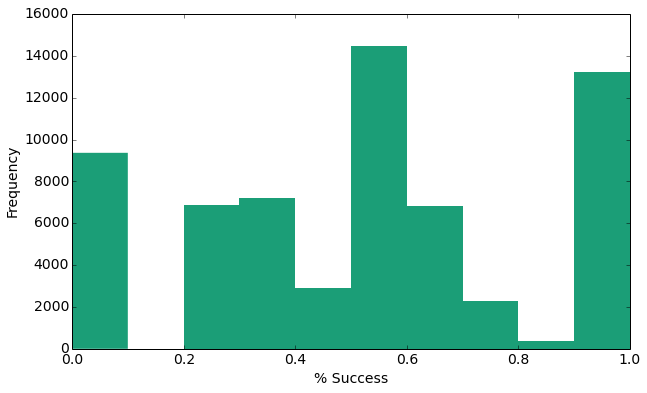

In [25]:
x = plt.hist(percent_success)
plt.xlabel('% Success')
plt.ylabel('Frequency')
print "total number of questions in test set: ", len(percent_success)
print "number of questions with at least 1 tag correctly predicted by our model: ", len([i for i in percent_success if i > 0])
print "percent of questions with at least 1 tag correctly predicted by our model:  %.2f%%" % (100* len([i for i in percent_success if i > 0])/float(len(percent_success)))
print "number of questions with all tags predicted correctly by our model:",  len([i for i in percent_success if i == 1])
print "percent of questions with all tags predicted correctly by our model: %.2f%%" % (100* len([i for i in percent_success if i == 1])/float(len(percent_success)))

We also tried using the same method but including in our input the body text and the user id. However, while the one including user id did not show a significant improvement in accuracy, the one that included the body text performed much worse. This could be due to the fact that there are simply too much noise in the body text (way too many stopwords that we should filter out). Take a look at [this post](http://stackoverflow.com/questions/20473604/tooltip-background-alternation) for example. Words like "single different background suitable fit draw custom size event particular setting" would all be filtered out, but a more sophistated methodology is necessary for us to figure out what the stop words for each posts are.

total number of questions in test set:  63521
number of questions with at least 1 tag correctly predicted by our model:  54314
percent of questions with at least 1 tag correctly predicted by our model:  85.51%
number of questions with all tags predicted correctly by our model: 12787
percent of questions with all tags predicted correctly by our model: 20.13%


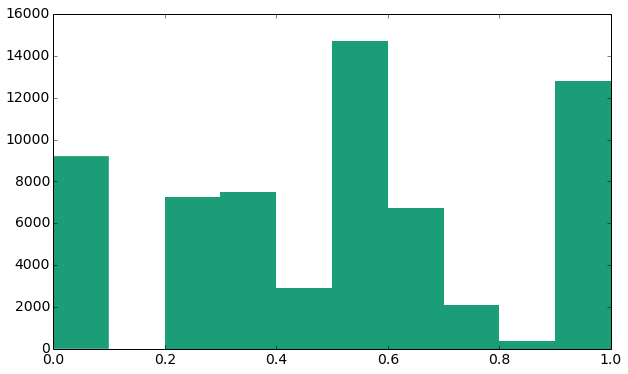

In [26]:
#Include user_id in our model since our explorary analysis shows that users tend to use similar tags as their past questions
userid_train = np.array(questions_train['User_id'])
tags_train = np.array(questions_train['Tags'])
titles_train = np.array(questions_train['Title'])
titles_and_userinfo_train = titles_train.copy()
for idx, title in enumerate(titles_and_userinfo_train):
    titles_and_userinfo_train[idx] = title + " id" + str(int(userid_train[idx]))
graph_w_userinfo = questions_graph(titles_and_userinfo_train, tags_train,stopwords)

titles_and_userinfo_test = np.array(questions_test['Title']).copy()
userid_test = np.array(questions_test['User_id'])
for idx, title in enumerate(titles_and_userinfo_test):
    titles_and_userinfo_test[idx] = title + " id" + str(int(userid_test[idx]))
predictions = make_predictions(titles_and_userinfo_test,stopwords,graph_w_userinfo)
tags = np.array(questions_test['Tags'])
percent_success = calc_acurracy(predictions, tags)

x = plt.hist(percent_success)
print "total number of questions in test set: ", len(percent_success)
print "number of questions with at least 1 tag correctly predicted by our model: ", len([i for i in percent_success if i > 0])
print "percent of questions with at least 1 tag correctly predicted by our model:  %.2f%%" % (100* len([i for i in percent_success if i > 0])/float(len(percent_success)))
print "number of questions with all tags predicted correctly by our model:",  len([i for i in percent_success if i == 1])
print "percent of questions with all tags predicted correctly by our model: %.2f%%" % (100* len([i for i in percent_success if i == 1])/float(len(percent_success)))
   

In [27]:
import pattern.web as pw

"""
Function
--------
body_to_text
  removes the code and tags from a body of a question

Parameters
----------
body : String
  string of raw html from question body
  
Returns
--------
A String
  plain string without any code, tags, or newlines
"""
def body_to_text(body):
    
    # remove code 
    text = pw.strip_between('<code>', '</code>', body)
    # remove tags whitespace, and newlines
    try:
        text = pw.plaintext(text).strip().replace('\n',' ')
    except:
        text = text.replace('\n',' ') 
    # convert text to lowercase
    return text.lower()

done with line one
done with setting up
done with graph
done with setting up
done with predictions
total number of questions in test set:  63521
number of questions with at least 1 tag correctly predicted by our model:  47351
percent of questions with at least 1 tag correctly predicted by our model:  74.54%
number of questions with all tags predicted correctly by our model: 7840
percent of questions with all tags predicted correctly by our model: 12.34%


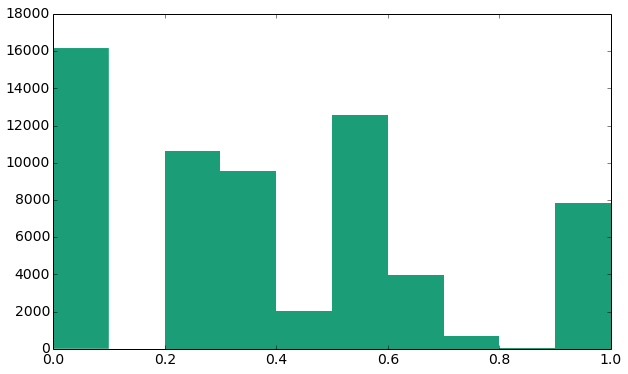

In [28]:
#Include body text
body_train = [body_to_text(i) for i in np.array(questions_train['Body'])]
print "done with line one"
tags_train = np.array(questions_train['Tags'])
titles_train = np.array(questions_train['Title'])
titles_and_userinfo_train = titles_train.copy()

for idx, title in enumerate(titles_and_userinfo_train):
    try:
        titles_and_userinfo_train[idx] = ''.join([title, " ", str(body_train[idx])]) 
    except:
        titles_and_userinfo_train[idx] = title
        
print "done with setting up"
graph_w_userinfo = questions_graph(titles_and_userinfo_train, tags_train,stopwords)
print "done with graph"
titles_and_userinfo_test = np.array(questions_test['Title']).copy()
body_test = [body_to_text(i) for i in np.array(questions_test['Body'])]
for idx, title in enumerate(titles_and_userinfo_test):
    try:
        titles_and_userinfo_test[idx] = ''.join([title, " ", str(body_test[idx])]) 
    except:
        titles_and_userinfo_test[idx] = title
print "done with setting up"
predictions = make_predictions(titles_and_userinfo_test,stopwords,graph_w_userinfo)
print "done with predictions"
tags = np.array(questions_test['Tags'])
percent_success = calc_acurracy(predictions, tags)

x = plt.hist(percent_success)
print "total number of questions in test set: ", len(percent_success)
print "number of questions with at least 1 tag correctly predicted by our model: ", len([i for i in percent_success if i > 0])
print "percent of questions with at least 1 tag correctly predicted by our model:  %.2f%%" % (100* len([i for i in percent_success if i > 0])/float(len(percent_success)))
print "number of questions with all tags predicted correctly by our model:",  len([i for i in percent_success if i == 1])
print "percent of questions with all tags predicted correctly by our model: %.2f%%" % (100* len([i for i in percent_success if i == 1])/float(len(percent_success)))
   

#### We concluded that the model using only the title text is the best for predicting tags. It predicts at least 1 tag correctly 85.26% of the time and all tags correctly 20.82% of the time.